В целом этот код сгенерил GPT.
В нем реализован метод Рунге Кутты 4 порядка, используется разностная аппроксимация для производной по координате. 
В том числе из-за плохо подходящей для данной задачи разностной аппроксимации, в решениях наблюдаются сильные расхождения.

В программе также используются формулы для перехода к размерным величинам (в системе СИ) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
rho0 = 1.225  # кг/м^3 (плотность воздуха на уровне моря)
p0   = 101325  # Па (атмосферное давление)
L0   = 1.0     # м (характерная длина)
U0   = np.sqrt(p0 / rho0) # м/с (характерная скорость, примерно скорость звука)
T0 = p0/(rho0*287) # K (Характерная температура)

def Conversion_in_Dim_quantities(x, rho, u, p, T):
    return x*L0, rho*rho0, u*U0, p*p0, T*T0

def Conversion_in_Dim_less_quantities(x, rho, u, p, T):
    return x/L0, rho/rho0, u/U0, p/p0, T/T0

def ConversionTime_in_Dim(t):
    return t/(U0/L0)

def ConversionTime_in_Dim_less(t):
    return t*(U0/L0)

0.028760091396636017 0.014380045698318009
0.0
0.004268455831962206
0.007968732757812041
0.01132477201823141
0.014462507024455458
0.017358356373699205
0.020065835979107965
0.022636608357015673
0.02510961270621927
0.027515679956338836


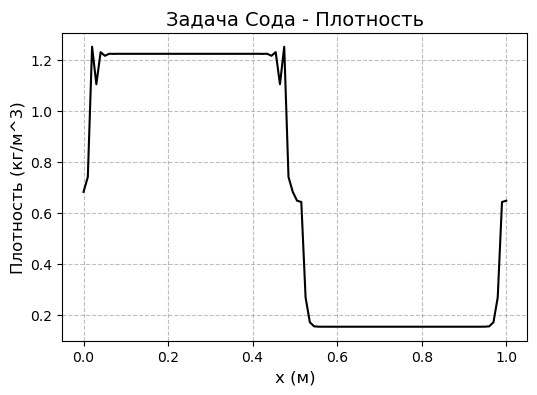

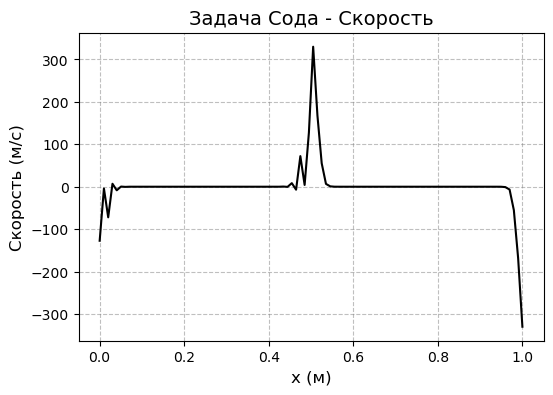

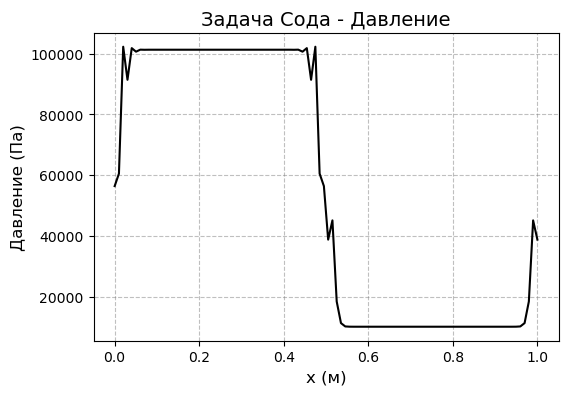

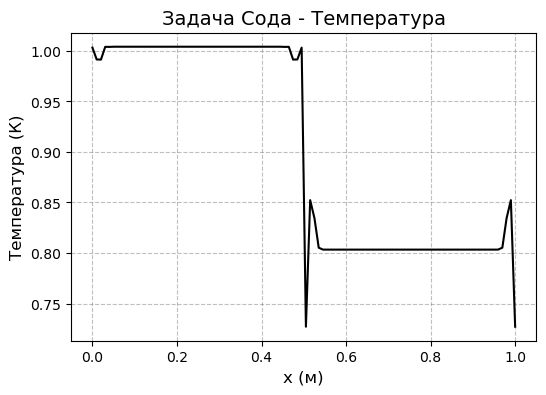

In [ ]:
# --------------------- Параметры задачи ---------------------
gamma = 1.4
nx = 100         # Количество точек сетки 
xmin = 0.0
xmax = 1.0
dx = (xmax - xmin) / (nx - 1)


t_end = 0.0001      # Конечное время в секундах 
t_end = ConversionTime_in_Dim_less(t_end) # Перевод в безразмерное время
# dt берется просто равным половине от конечного времени
dt = t_end/2
# В дальнейшем в цикле dt вычисляется на основе безразмерного cfl
cfl = 0.5          # Число Куранта

# --------------- Инициализация сетки ---------------------
x = np.linspace(xmin, xmax, nx)
# --------------- Начальные условия (безразмерные, задача Сода) -----------------
rho_prime = np.ones(nx)
u_prime = np.zeros(nx)
p_prime = np.ones(nx)
T_prime = np.ones(nx)
rho_prime[x < 0.5] = 1.0
u_prime[x < 0.5] = 0.0
p_prime[x < 0.5] = 1.0
rho_prime[x >= 0.5] = 0.125
u_prime[x >= 0.5] = 0.0
p_prime[x >= 0.5] = 0.1
T_prime = p_prime/rho_prime/287
# --------------------- Перевод в размерные величины и обратно (СИ) ---------------------
# Этот переход сделан только для удобства обозначений, расчеты будут в безразмерных
x, rho, u, p, T = Conversion_in_Dim_quantities(x, rho_prime, u_prime, p_prime, T_prime)
x, rho, u, p, T = Conversion_in_Dim_less_quantities(x, rho, u, p, T)
# Дальнейший расчет идет в БЕЗРАЗМЕРНЫХ параметрах

# --------------------- Функция расчета потоков (теперь использует размерные переменные) ---------------------
def calculate_fluxes(rho, u, p, gamma):
    F_rho  = rho * u
    F_rhou = rho * u**2 + p
    F_E    = (0.5*rho*u**2 + p/(gamma - 1))*u
    return F_rho, F_rhou, F_E

# --------------------- Функция обновления переменных (RK4) ---------------------
def rk4_step(rho, u, p, dx, dt, gamma):
    E = p / (gamma - 1) + 0.5 * rho * u**2
    F_rho, F_rhou, F_E = calculate_fluxes(rho, u, p, gamma)

    # k1
    drho_dt1  = - (np.roll(F_rho, -1) - np.roll(F_rho, 1)) / (2 * dx)
    drhou_dt1 = - (np.roll(F_rhou, -1) - np.roll(F_rhou, 1)) / (2 * dx)
    dE_dt1    = - (np.roll(F_E, -1) - np.roll(F_E, 1)) / (2 * dx)
    k1_rho  = dt * drho_dt1
    k1_rhou = dt * drhou_dt1
    k1_E    = dt * dE_dt1
    
    # k2
    rho_temp = rho + k1_rho / 2
    u_temp   = u + k1_rhou / (2*rho) / 2
    E_temp = E + k1_E / 2
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_E = calculate_fluxes(rho_temp, u_temp, p_temp, gamma)
    drho_dt2  = - (np.roll(F_rho, -1) - np.roll(F_rho, 1)) / (2 * dx)
    drhou_dt2 = - (np.roll(F_rhou, -1) - np.roll(F_rhou, 1)) / (2 * dx)
    dE_dt2    = - (np.roll(F_E, -1) - np.roll(F_E, 1)) / (2 * dx)
    k2_rho  = dt * drho_dt2
    k2_rhou = dt * drhou_dt2
    k2_E    = dt * dE_dt2
        
    # k3
    rho_temp = rho + k2_rho / 2
    u_temp   = u + k2_rhou / (2*rho) / 2
    E_temp = E + k2_E / 2
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_E = calculate_fluxes(rho_temp, u_temp, p_temp, gamma)
    drho_dt3  = - (np.roll(F_rho, -1) - np.roll(F_rho, 1)) / (2 * dx)
    drhou_dt3 = - (np.roll(F_rhou, -1) - np.roll(F_rhou, 1)) / (2 * dx)
    dE_dt3    = - (np.roll(F_E, -1) - np.roll(F_E, 1)) / (2 * dx)
    k3_rho  = dt * drho_dt3
    k3_rhou = dt * drhou_dt3
    k3_E    = dt * dE_dt3
        
    # k4
    rho_temp = rho + k3_rho
    u_temp   = u + k3_rhou / (2*rho)
    E_temp = E + k3_E
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_E = calculate_fluxes(rho_temp, u_temp, p_temp, gamma)
    drho_dt4  = - (np.roll(F_rho, -1) - np.roll(F_rho, 1)) / (2 * dx)
    drhou_dt4 = - (np.roll(F_rhou, -1) - np.roll(F_rhou, 1)) / (2 * dx)
    dE_dt4    = - (np.roll(F_E, -1) - np.roll(F_E, 1)) / (2 * dx)
    k4_rho  = dt * drho_dt4
    k4_rhou = dt * drhou_dt4
    k4_E    = dt * dE_dt4

    # Обновление переменных
    rho = rho + (k1_rho + 2*k2_rho + 2*k3_rho + k4_rho) / 6
    u   = u   + (k1_rhou + 2*k2_rhou + 2*k3_rhou + k4_rhou) / 6
    E   = E   + (k1_E + 2*k2_E + 2*k3_E + k4_E) / 6
    p = (gamma - 1)*(E - 0.5*rho*u**2)
    return rho, u, p

# --------------------- Временная петля ---------------------
t = 0.0
print(t_end, dt)
while t < t_end:
    print(t)
    # Ограничение шага по времени (теперь с размерной скоростью звука)
    a = np.sqrt(gamma * p / rho)  #скорость звука
    dt = min(dt, cfl * dx / np.max(np.abs(u) + a)) # Шаг по времени связываем со скоростью звука
    rho, u, p = rk4_step(rho, u, p, dx, dt, gamma)
    T = p/(rho*287) # K
    t += dt


# --------------------- Визуализация результатов ---------------------

# Перевод в размерные значения
x, rho, u, p, T = Conversion_in_Dim_quantities(x, rho, u, p, T)


# Общие настройки для графиков
fig_size = (6, 4) 
line_color = 'black'
grid_linestyle = '--'
grid_alpha = 0.5
grid_color = 'gray'

def create_plot(x_data, y_data, x_label, y_label, title):
    plt.figure(figsize=fig_size) 
    plt.plot(x_data, y_data, color=line_color)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)
    # plt.ylim(0,2) # Пример: установить предел по оси Y от 0 до 2
    plt.show()
    plt.close()

# Density plot
create_plot(x, rho, 'x (м)', 'Плотность (кг/м^3)', 'Плотность')
#del x, rho

# Velocity plot
x = np.linspace(xmin, xmax, nx)
create_plot(x, u, 'x (м)', 'Скорость (м/с)', 'Скорость')
#del x, u

# Pressure plot
x = np.linspace(xmin, xmax, nx)
create_plot(x, p, 'x (м)', 'Давление (Па)', 'Давление')
#del x, p
# Temperature plot
x = np.linspace(xmin, xmax, nx)
create_plot(x, T, 'x (м)', 'Температура (К)', 'Температура')
#del x, T